# A1: Data Curation

### Geoffrey Li

DATA 512

English Wikipedia page views 2007 - 2019

October 3, 2019


This code is made available for re-use under a [CC0 license](https://creativecommons.org/share-your-work/public-domain/cc0/). 


In [1]:
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
import datetime

## Define API call parameters and call API

Denotes the API call structure.

In [2]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

Define the API call parameters.

In [3]:
params_legacy_desktop = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2008010100",
                # for end use 1st day of month following final month of data
                 "end" : "2019090100"
                    }

params_legacy_mobile = {"project" : "en.wikipedia.org",
                 "access-site" : "mobile-site",
                 "granularity" : "monthly",
                 "start" : "2008010100",
                # for end use 1st day of month following final month of data
                 "end" : "2019090100"
                    }

params_pageviews_desktop = {"project" : "en.wikipedia.org",
                    "access" : "desktop",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2008010100",
                    # for end use 1st day of month following final month of data
                    "end" : '2019090100'
                        }

params_pageviews_mobile_web = {"project" : "en.wikipedia.org",
                    "access" : "mobile-web",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2008010100",
                    # for end use 1st day of month following final month of data
                    "end" : '2019090100'
                        }

params_pageviews_mobile_app = {"project" : "en.wikipedia.org",
                    "access" : "mobile-app",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2008010100",
                    # for end use 1st day of month following final month of data
                    "end" : '2019090100'
                        }

headers = {
    'User-Agent': 'https://github.com/geoffreyli',
    'From': 'geoffli@uw.edu'
}

Define a function to call the APIs.

In [4]:
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

Call the APIs to download the data.

In [5]:
monthly_legacy_desktop = api_call(endpoint_legacy, params_legacy_desktop)
monthly_legacy_mobile = api_call(endpoint_legacy, params_legacy_mobile)

monthly_pageviews_desktop = api_call(endpoint_pageviews, params_pageviews_desktop)
monthly_pageviews_mobile_web = api_call(endpoint_pageviews, params_pageviews_mobile_web)
monthly_pageviews_mobile_app = api_call(endpoint_pageviews, params_pageviews_mobile_app)

## Dump raw data into JSON files

Create JSON files to dump the raw data, to store for later use.

In [6]:
with open('./legacy_pagecounts_desktop-site_200801-201908.json', 'w') as json_file:
  json.dump(monthly_legacy_desktop, json_file)

with open('./legacy_pagecounts_mobile-site_200801-201908.json', 'w') as json_file:
  json.dump(monthly_legacy_mobile, json_file)

In [7]:
with open('./pageviews_desktop_200801-201908.json', 'w') as json_file:
  json.dump(monthly_pageviews_desktop, json_file)

with open('./pageviews_mobile-web_200801-201908.json', 'w') as json_file:
  json.dump(monthly_pageviews_mobile_web, json_file)

with open('./pageviews_mobile-app_200801-201908.json', 'w') as json_file:
  json.dump(monthly_pageviews_mobile_app, json_file)

## Reading API data into pandas dataframes

Store the API data into pandas dataframes.

In [8]:
monthly_legacy_desktop_raw = pd.DataFrame(monthly_legacy_desktop['items'])
monthly_legacy_mobile_raw = pd.DataFrame(monthly_legacy_mobile['items'])

monthly_pageviews_desktop_raw = pd.DataFrame(monthly_pageviews_desktop['items'])
monthly_pageviews_mobile_web_raw = pd.DataFrame(monthly_pageviews_mobile_web['items'])
monthly_pageviews_mobile_app_raw = pd.DataFrame(monthly_pageviews_mobile_app['items'])

## Data processing steps

Combine the mobile-web and mobile-app data from the new API (pageviews), then group by month to get monthly views.

In [9]:
monthly_pageviews_mobile_all_raw = \
    pd.concat(
        [monthly_pageviews_mobile_web_raw, monthly_pageviews_mobile_app_raw]
    )

monthly_pageviews_mobile_all_raw['access_mapped'] = 'mobile'

monthly_pageviews_mobile_all = \
    monthly_pageviews_mobile_all_raw.groupby(['access_mapped','timestamp'])['views'].sum().reset_index()

Combine all data into one dataframe across all APIs and all modalities.

In [10]:
monthly_summary = \
    monthly_legacy_desktop_raw[['timestamp','count']]\
    .rename(columns={'count':'pagecount_desktop_views'})\
    .merge(
        monthly_legacy_mobile_raw[['timestamp','count']]\
        .rename(columns={'count':'pagecount_mobile_views'}),
        how='outer', on='timestamp'
    )\
    .merge(
        monthly_pageviews_desktop_raw[['timestamp','views']]\
        .rename(columns={'views':'pageview_desktop_views'}),
        how='outer', on='timestamp'
    )\
    .merge(
        monthly_pageviews_mobile_all[['timestamp','views']]\
        .rename(columns={'views':'pageview_mobile_views'}),
        how='outer', on='timestamp'
    )

monthly_summary.fillna(0, inplace=True)

monthly_summary['pagecount_all_views'] = \
    monthly_summary['pagecount_desktop_views'] + monthly_summary['pagecount_mobile_views']

monthly_summary['pageview_all_views'] = \
    monthly_summary['pageview_desktop_views'] + monthly_summary['pageview_mobile_views']

Extract the year and the month.

In [11]:
monthly_summary['year'] = monthly_summary['timestamp'].str[:4]
monthly_summary['month'] = monthly_summary['timestamp'].str[4:6]

Order the columns.

In [12]:
monthly_summary = monthly_summary[[
    'year','month','pagecount_all_views','pagecount_desktop_views','pagecount_mobile_views',
    'pageview_all_views','pageview_desktop_views','pageview_mobile_views'
]]

Convert the floats to ints.

In [13]:
monthly_summary['pagecount_all_views'] = monthly_summary['pagecount_all_views'].astype(int)
monthly_summary['pagecount_desktop_views'] = monthly_summary['pagecount_desktop_views'].astype(int)
monthly_summary['pagecount_mobile_views'] = monthly_summary['pagecount_mobile_views'].astype(int)
monthly_summary['pageview_all_views'] = monthly_summary['pageview_all_views'].astype(int)
monthly_summary['pageview_desktop_views'] = monthly_summary['pageview_desktop_views'].astype(int)
monthly_summary['pageview_mobile_views'] = monthly_summary['pageview_mobile_views'].astype(int)

## Export final summarized data file to CSV

Export the final summarized data frame into a CSV file for later use.

In [14]:
# Following the explicit instructions on the Assignment page, even through the date range is incorrect
# Actual date range is: 200801-201909
monthly_summary.to_csv('./en-wikipedia_traffic_200712-201809.csv')

##  Data visualization: Time Series Graph

Plot the data in a time series graph; save the output as a PNG file.

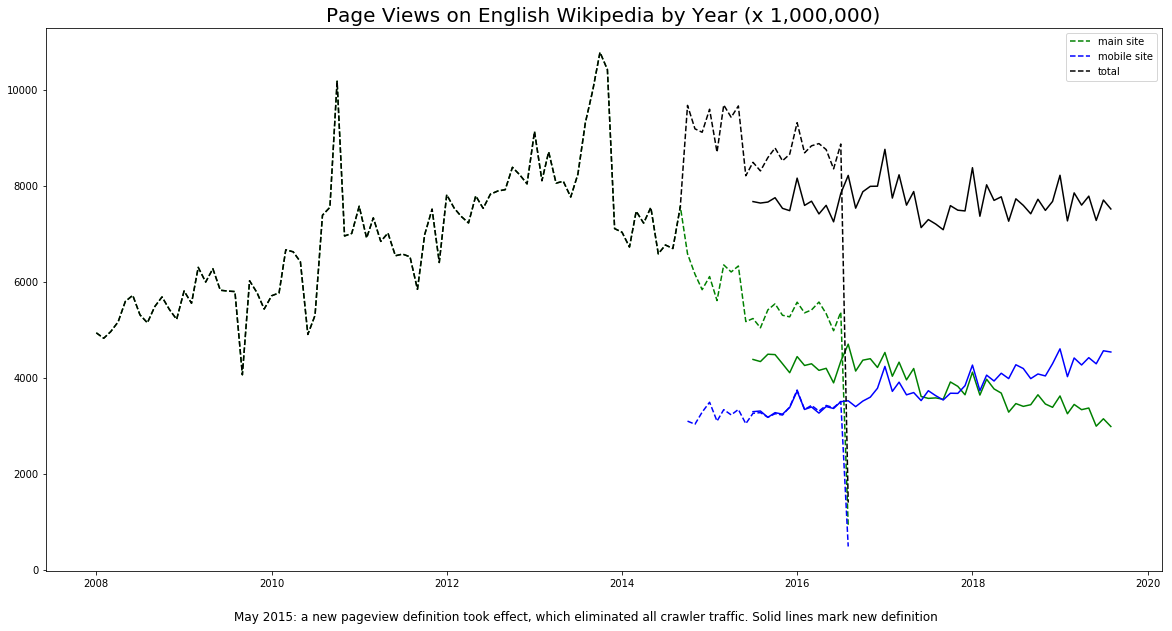

In [47]:
plt.figure(figsize=(20,10))

plt.title('Page Views on English Wikipedia by Year (x 1,000,000)', fontsize=20)

plt.suptitle('May 2015: a new pageview definition took effect, which eliminated all crawler traffic. \
Solid lines mark new definition', y=0.07, fontsize=12)


plt.plot(pd.to_datetime(monthly_summary[monthly_summary['pagecount_desktop_views'] > 0]\
                        .assign(day = 1)[['year', 'month', 'day']]), 
         monthly_summary[monthly_summary['pagecount_desktop_views'] > 0]['pagecount_desktop_views']/1e6,
         color='green', linestyle='dashed', label='main site')

plt.plot(pd.to_datetime(monthly_summary[monthly_summary['pageview_desktop_views'] > 0]\
                        .assign(day = 1)[['year', 'month', 'day']]), 
         monthly_summary[monthly_summary['pageview_desktop_views'] > 0]['pageview_desktop_views']/1e6,
         color='green', linestyle='solid', label='_nolegend_')

plt.plot(pd.to_datetime(monthly_summary[monthly_summary['pagecount_mobile_views'] > 0]\
                        .assign(day = 1)[['year', 'month', 'day']]), 
         monthly_summary[monthly_summary['pagecount_mobile_views'] > 0]['pagecount_mobile_views']/1e6,
         color='blue', linestyle='dashed', label='mobile site')

plt.plot(pd.to_datetime(monthly_summary[monthly_summary['pageview_mobile_views'] > 0]\
                        .assign(day = 1)[['year', 'month', 'day']]), 
         monthly_summary[monthly_summary['pageview_mobile_views'] > 0]['pageview_mobile_views']/1e6,
         color='blue', linestyle='solid', label='_nolegend_')

plt.plot(pd.to_datetime(monthly_summary[monthly_summary['pagecount_all_views'] > 0]\
                        .assign(day = 1)[['year', 'month', 'day']]), 
         monthly_summary[monthly_summary['pagecount_all_views'] > 0]['pagecount_all_views']/1e6,
         color='black', linestyle='dashed', label='total')

plt.plot(pd.to_datetime(monthly_summary[monthly_summary['pageview_all_views'] > 0]\
                        .assign(day = 1)[['year', 'month', 'day']]), 
         monthly_summary[monthly_summary['pageview_all_views'] > 0]['pageview_all_views']/1e6,
         color='black', linestyle='solid', label='_nolegend_')


plt.legend()

plt.savefig('./page-views-fig.png')